In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths to the image directories
# Paths need to be modified locally after dataset is downloaded from Kaggle.

train_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/train/DR'
train_no_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/train/No_DR'

test_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/test/DR'
test_no_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/test/No_DR'

valid_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/valid/DR'
valid_no_dr_path = '/kaggle/input/diagnosis-of-diabetic-retinopathy/valid/No_DR'

# Function to count the number of files in a directory
def count_files(directory):
    return len([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])

# Count the number of images in each category
train_dr_count = count_files(train_dr_path)
train_no_dr_count = count_files(train_no_dr_path)

test_dr_count = count_files(test_dr_path)
test_no_dr_count = count_files(test_no_dr_path)

valid_dr_count = count_files(valid_dr_path)
valid_no_dr_count = count_files(valid_no_dr_path)

# Plotting the bar chart
categories = ['Train DR', 'Train No DR', 'Test DR', 'Test No DR', 'Valid DR', 'Valid No DR']
counts = [train_dr_count, train_no_dr_count, test_dr_count, test_no_dr_count, valid_dr_count, valid_no_dr_count]

plt.bar(categories, counts, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Diabetic Retinopathy Dataset')
plt.show()

# About the dataset
The dataset comprises a collection of high-resolution retinal images suitable for training and evaluating automated systems for Diabetic Retinopathy (DR) detection and grading. The images capture various imaging conditions, reflecting real-world clinical scenarios. Each image has been meticulously assessed by a medical professional for the presence of DR and assigned a corresponding grade on a scale between 0 and 1, with the following interpretation: Grade 0: Diabetic Retinopathy present Grade 1: No Diabetic Retinopathy This rich dataset holds immense potential for advancing the development of automated DR detection and grading algorithms. Its large size, encompassing diverse image conditions, allows for robust training and reliable performance evaluation. Moreover, the inclusion of expert-annotated grades provides a valuable ground truth for training and assessing model performance. The dataset's key characteristics include: This comprehensive dataset will be invaluable for researchers and developers working on automated DR detection and grading systems, ultimately contributing to improved early detection, timely intervention, and personalized treatment for individuals with diabetes.

We now try to see a few example images

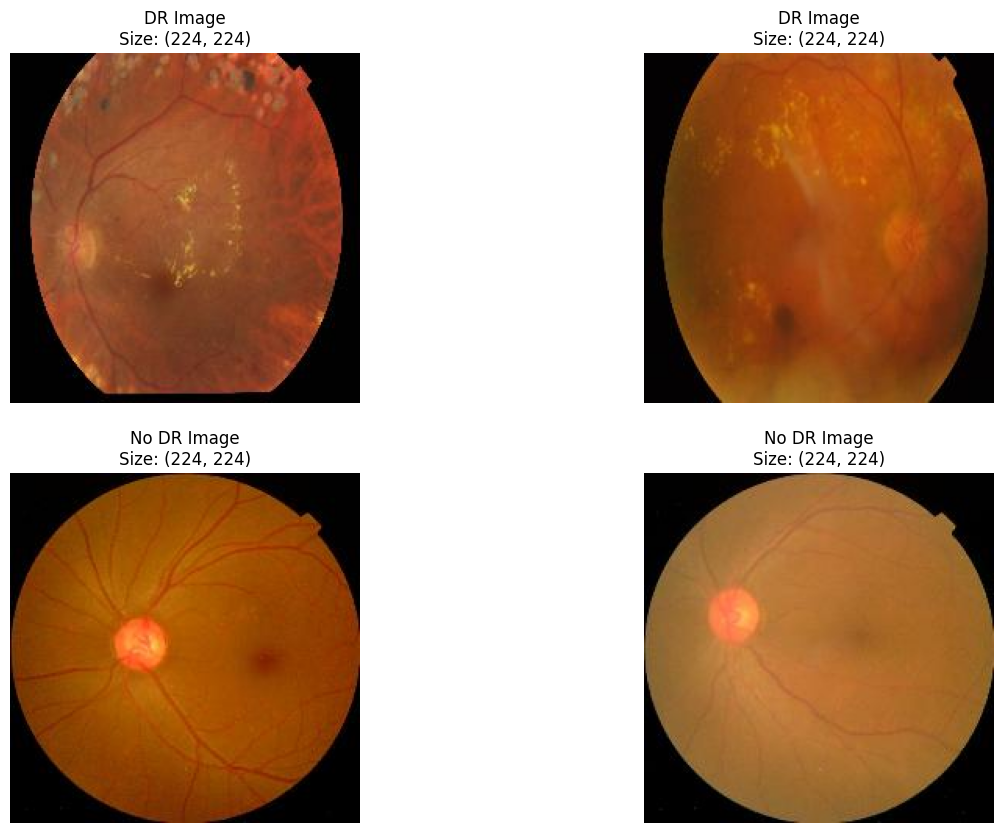

In [ ]:
from PIL import Image
import random
import matplotlib.pyplot as plt

# Function to get the size of an image
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

# Function to plot random images from both categories in a subplot
def plot_random_images(category1_path, category1_name, category2_path, category2_name, num_images=4):
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_images):
        if i < num_images // 2:
            category_path = category1_path
            category_name = category1_name
        else:
            category_path = category2_path
            category_name = category2_name

        file_list = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        random_file = random.choice(file_list)
        image_path = os.path.join(category_path, random_file)

        image_size = get_image_size(image_path)
        axes[i].imshow(Image.open(image_path))
        axes[i].set_title(f"{category_name} Image\nSize: {image_size}")
        axes[i].axis('off')

    plt.show()

# Plot random images in a subplot
plot_random_images(train_dr_path, "DR", train_no_dr_path, "No DR", num_images=4)

Lets build a Dataloader for we would be using for training the next few models

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



# Create datasets
train_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/train', transform=transform)
test_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/test', transform=transform)
valid_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/valid', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We first train the model with ResNet50 and Plot the ROC and Confusion Matrix

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 275MB/s] 


Epoch 10/100, Train Accuracy: 0.9586, Valid Accuracy: 0.9548
Early stopping! No improvement for 10 epochs.


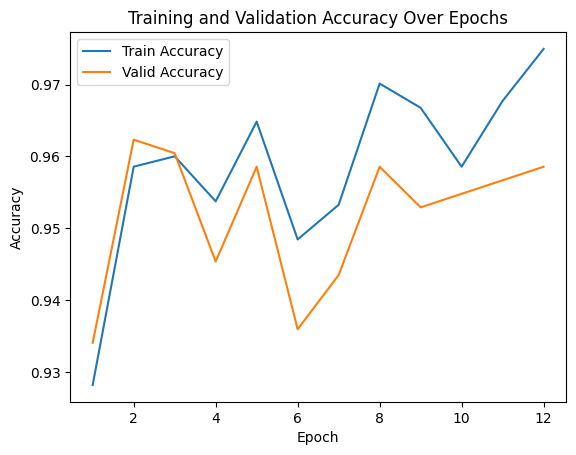

Best Accuracy on Test Set (ResNet): 95.67%


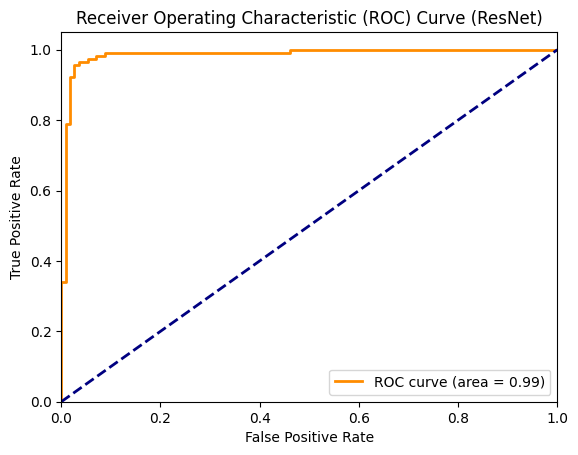

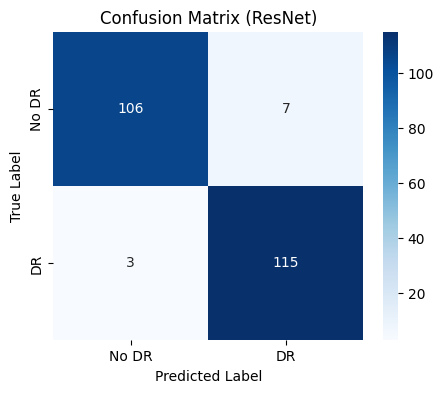

In [ ]:
# Load the pre-trained ResNet-50 model
resnet_model = models.resnet50(pretrained=True)

# Specify the device, e.g., 'cuda' for GPU or 'cpu' for CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Freeze all the layers in the pre-trained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the GPU if available
resnet_model = resnet_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Variables for storing best accuracy and the corresponding model
best_accuracy_resnet = 0.0
best_model_resnet = None

# Lists for storing training and validation accuracies for plotting
train_accuracies = []
valid_accuracies = []

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_valid_loss = float('inf')

# Training loop for 100 epochs (with early stopping)
num_epochs = 100

for epoch in range(num_epochs):
    resnet_model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training set
    resnet_model.eval()
    train_correct = 0
    train_total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / train_total

    # Evaluate the model on the validation set
    resnet_model.eval()
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = valid_correct / valid_total

    # Save the model with the best accuracy on the validation set
    if valid_accuracy > best_accuracy_resnet:
        best_accuracy_resnet = valid_accuracy
        best_model_resnet = resnet_model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Store accuracies for plotting
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Print and save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping! No improvement for {} epochs.".format(early_stopping_patience))
        break

# Plot the accuracy change with epochs
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Load the best model and evaluate it on the test set
resnet_model.load_state_dict(best_model_resnet)
resnet_model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

test_accuracy_resnet = test_correct / test_total
print(f'Best Accuracy on Test Set (ResNet): {100 * test_accuracy_resnet:.2f}%')

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Plot ROC Curve for ResNet
fpr_resnet, tpr_resnet, thresholds_resnet = roc_curve(all_labels, all_predictions)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure()
plt.plot(fpr_resnet, tpr_resnet, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_resnet:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (ResNet)')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for ResNet
cm_resnet = confusion_matrix(all_labels, (all_predictions > 0.5).astype(int))
plt.figure(figsize=(5, 4))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=["No DR", "DR"], yticklabels=["No DR", "DR"])
plt.title("Confusion Matrix (ResNet)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
resnet_sensitivity = 106/109
resnet_specificity = 115/122

Next, we will use effiecientnet

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a5bf59a693e6e7a7e76ae3063acba322329a999e4d68b0ac744e9263c3d71702
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The same dataloader has been used, but with the efficientnet pretrained model now

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 181MB/s] 


Loaded pretrained weights for efficientnet-b2
Epoch 10/100, Train Accuracy: 0.9827, Valid Accuracy: 0.9623
Early stopping! No improvement for 10 epochs.


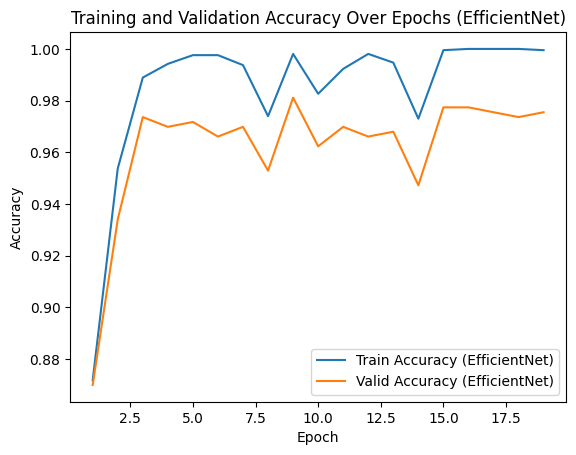

Best Accuracy on Test Set (EfficientNet): 97.84%


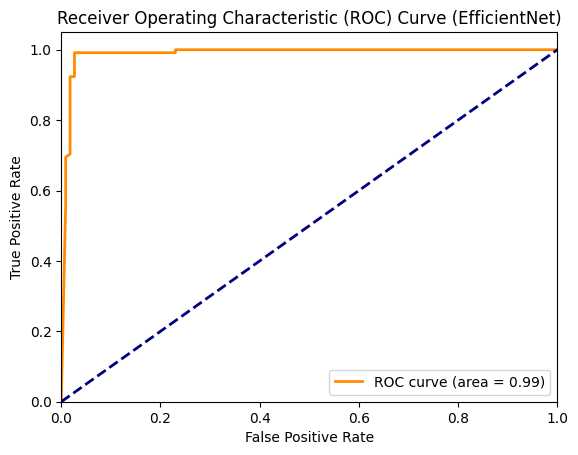

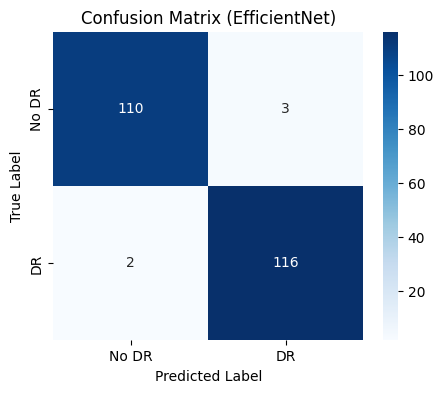

In [ ]:
# Load the pre-trained EfficientNet model
effnet_model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=len(train_dataset.classes))

# Move the model to the GPU if available
effnet_model = effnet_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=0.001)

# Variables for storing best accuracy and the corresponding model
best_accuracy_effnet = 0.0
best_model_effnet = None

# Lists for storing training and validation accuracies for plotting
train_accuracies_effnet = []
valid_accuracies_effnet = []

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_valid_loss_effnet = float('inf')

# Training loop for 100 epochs (with early stopping)
num_epochs = 100

for epoch in range(num_epochs):
    effnet_model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = effnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training set
    effnet_model.eval()
    train_correct = 0
    train_total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = effnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_accuracy_effnet = train_correct / train_total

    # Evaluate the model on the validation set
    effnet_model.eval()
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = effnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy_effnet = valid_correct / valid_total

    # Save the model with the best accuracy on the validation set
    if valid_accuracy_effnet > best_accuracy_effnet:
        best_accuracy_effnet = valid_accuracy_effnet
        best_model_effnet = effnet_model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Store accuracies for plotting
    train_accuracies_effnet.append(train_accuracy_effnet)
    valid_accuracies_effnet.append(valid_accuracy_effnet)

    # Print and save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy_effnet:.4f}, Valid Accuracy: {valid_accuracy_effnet:.4f}')

    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping! No improvement for {} epochs.".format(early_stopping_patience))
        break

# Plot the accuracy change with epochs for EfficientNet
plt.plot(range(1, len(train_accuracies_effnet) + 1), train_accuracies_effnet, label='Train Accuracy (EfficientNet)')
plt.plot(range(1, len(valid_accuracies_effnet) + 1), valid_accuracies_effnet, label='Valid Accuracy (EfficientNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs (EfficientNet)')
plt.legend()
plt.show()

# Load the best model and evaluate it on the test set for EfficientNet
effnet_model.load_state_dict(best_model_effnet)
effnet_model.eval()
test_correct_effnet = 0
test_total_effnet = 0
all_labels_effnet = []
all_predictions_effnet = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = effnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total_effnet += labels.size(0)
        test_correct_effnet += (predicted == labels).sum().item()

        all_labels_effnet.extend(labels.cpu().numpy())
        all_predictions_effnet.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

test_accuracy_effnet = test_correct_effnet / test_total_effnet
print(f'Best Accuracy on Test Set (EfficientNet): {100 * test_accuracy_effnet:.2f}%')

# Convert the lists to numpy arrays for EfficientNet
all_labels_effnet = np.array(all_labels_effnet)
all_predictions_effnet = np.array(all_predictions_effnet)

# Plot ROC Curve for EfficientNet
fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(all_labels_effnet, all_predictions_effnet)
roc_auc_effnet = auc(fpr_effnet, tpr_effnet)

plt.figure()
plt.plot(fpr_effnet, tpr_effnet, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_effnet:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (EfficientNet)')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for EfficientNet
cm_effnet = confusion_matrix(all_labels_effnet, (all_predictions_effnet > 0.5).astype(int))
plt.figure(figsize=(5, 4))
sns.heatmap(cm_effnet, annot=True, fmt="d", cmap="Blues", xticklabels=["No DR", "DR"], yticklabels=["No DR", "DR"])
plt.title("Confusion Matrix (EfficientNet)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
effnet_sensitivity = 110/112
effnet_specificity = 116/119

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_small
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The next model that we want to try is mobilenet V3, and see how such a light model work on this dataset

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 85.1MB/s]


Epoch 10/100, Train Accuracy: 0.9976, Valid Accuracy: 0.9661
Early stopping! No improvement for 10 epochs.


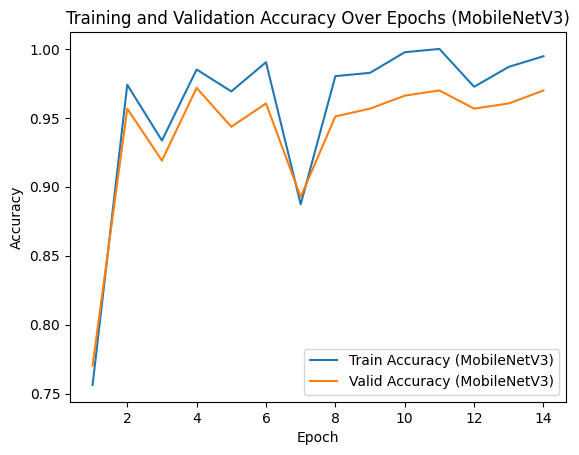

Best Accuracy on Test Set (MobileNetV3): 97.84%


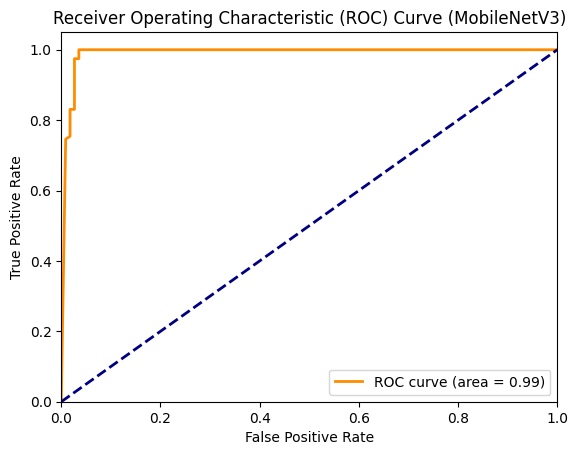

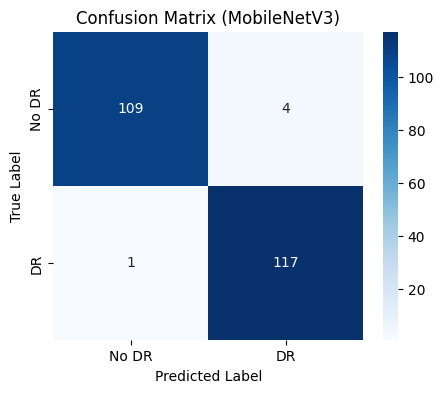

In [ ]:
# Load the pre-trained MobileNetV3 Small model
mbnet_model = mobilenet_v3_small(pretrained=True)

# Modify the fully connected layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
mbnet_model.classifier[3] = nn.Linear(mbnet_model.classifier[3].in_features, num_classes)

# Move the model to the GPU if available
mbnet_model = mbnet_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mbnet_model.parameters(), lr=0.001)

# Variables for storing best accuracy and the corresponding model
best_accuracy_mbnet = 0.0
best_model_mbnet = None

# Lists for storing training and validation accuracies for plotting
train_accuracies_mbnet = []
valid_accuracies_mbnet = []

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_valid_loss_mbnet = float('inf')

# Training loop for 100 epochs (with early stopping)
num_epochs = 100

for epoch in range(num_epochs):
    mbnet_model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mbnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training set
    mbnet_model.eval()
    train_correct = 0
    train_total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mbnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_accuracy_mbnet = train_correct / train_total

    # Evaluate the model on the validation set
    mbnet_model.eval()
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mbnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy_mbnet = valid_correct / valid_total

    # Save the model with the best accuracy on the validation set
    if valid_accuracy_mbnet > best_accuracy_mbnet:
        best_accuracy_mbnet = valid_accuracy_mbnet
        best_model_mbnet = mbnet_model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Store accuracies for plotting
    train_accuracies_mbnet.append(train_accuracy_mbnet)
    valid_accuracies_mbnet.append(valid_accuracy_mbnet)

    # Print and save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy_mbnet:.4f}, Valid Accuracy: {valid_accuracy_mbnet:.4f}')

    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping! No improvement for {} epochs.".format(early_stopping_patience))
        break

# Plot the accuracy change with epochs for MobileNetV3
plt.plot(range(1, len(train_accuracies_mbnet) + 1), train_accuracies_mbnet, label='Train Accuracy (MobileNetV3)')
plt.plot(range(1, len(valid_accuracies_mbnet) + 1), valid_accuracies_mbnet, label='Valid Accuracy (MobileNetV3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs (MobileNetV3)')
plt.legend()
plt.show()

# Load the best model and evaluate it on the test set for MobileNetV3
mbnet_model.load_state_dict(best_model_mbnet)
mbnet_model.eval()
test_correct_mbnet = 0
test_total_mbnet = 0
all_labels_mbnet = []
all_predictions_mbnet = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mbnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total_mbnet += labels.size(0)
        test_correct_mbnet += (predicted == labels).sum().item()

        all_labels_mbnet.extend(labels.cpu().numpy())
        all_predictions_mbnet.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

test_accuracy_mbnet = test_correct_mbnet / test_total_mbnet
print(f'Best Accuracy on Test Set (MobileNetV3): {100 * test_accuracy_mbnet:.2f}%')

# Convert the lists to numpy arrays for MobileNetV3
all_labels_mbnet = np.array(all_labels_mbnet)
all_predictions_mbnet = np.array(all_predictions_mbnet)

# Plot ROC Curve for MobileNetV3
fpr_mbnet, tpr_mbnet, thresholds_mbnet = roc_curve(all_labels_mbnet, all_predictions_mbnet)
roc_auc_mbnet = auc(fpr_mbnet, tpr_mbnet)

plt.figure()
plt.plot(fpr_mbnet, tpr_mbnet, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mbnet:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (MobileNetV3)')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for MobileNetV3
cm_mbnet = confusion_matrix(all_labels_mbnet, (all_predictions_mbnet > 0.5).astype(int))
plt.figure(figsize=(5, 4))
sns.heatmap(cm_mbnet, annot=True, fmt="d", cmap="Blues", xticklabels=["No DR", "DR"], yticklabels=["No DR", "DR"])
plt.title("Confusion Matrix (MobileNetV3)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
mbnet_sensitivity = 109/110
mbnet_sensitivity = 117/121

Our Hypothesis however was that, vision transformers will have significantly better performance comparing to cnn based models, so for this we would use pretrained ViT model

In [ ]:
pip install pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11114 sha256=a05e72f426af35f3265260bf2d37c46421170dd41c632e91d2e6105588f011c6
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch_pretrained_vit
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pytorch_pretrained_vit import ViT
vit_model = ViT('B_16_imagenet1k', pretrained=True)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:01<00:00, 283MB/s] 


Loaded pretrained weights.


the input image size of this model is different, thus we would need to change the dataloader

In [ ]:
print(vit_model.image_size)

(384, 384)


In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize(vit_model.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create datasets
train_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/train', transform=transform)
test_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/test', transform=transform)
valid_dataset = ImageFolder(root='/kaggle/input/diagnosis-of-diabetic-retinopathy/valid', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)




Loading the model to device and setting parameters

In [ ]:
# Specify the device, e.g., 'cuda' for GPU or 'cpu' for CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Freeze all the layers in the pre-trained model
for param in vit_model.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
vit_model.fc = nn.Linear(vit_model.fc.in_features, num_classes)

# Move the model to the GPU if available
vit_model = vit_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.fc.parameters(), lr=0.001)

# Variables for storing best accuracy and the corresponding model
best_accuracy_vit = 0.0
best_model_vit = None


Setting early stoppage with a possible 100 epochs of training, just like the previous models

In [ ]:
# Lists for storing training and validation accuracies for plotting
train_accuracies = []
valid_accuracies = []

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_valid_loss = float('inf')

# Training loop for 100 epochs (with early stopping)
num_epochs = 100


In [ ]:
for epoch in range(num_epochs):
    vit_model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #print("this loop is running")

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training set
    vit_model.eval()
    train_correct = 0
    train_total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            #print("training loop running")
            train_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / train_total
    print(f'Train Accuracy: {train_accuracy:.4f}')

    # Evaluate the model on the validation set
    vit_model.eval()
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            #print("valid loop running")
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = valid_correct / valid_total
    print(f'Valid Accuracy: {valid_accuracy:.4f}')

    # Save the model with the best accuracy on the validation set
    if valid_accuracy > best_accuracy_vit:
        best_accuracy_vit = valid_accuracy
        best_model_vit = vit_model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Store accuracies for plotting
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Print and save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping! No improvement for {} epochs.".format(early_stopping_patience))
        break



Train Accuracy: 0.9605
Valid Accuracy: 0.9567
Train Accuracy: 0.9735
Valid Accuracy: 0.9718
Train Accuracy: 0.9566
Valid Accuracy: 0.9529
Train Accuracy: 0.9740
Valid Accuracy: 0.9736
Train Accuracy: 0.9740
Valid Accuracy: 0.9718
Train Accuracy: 0.9648
Valid Accuracy: 0.9642
Train Accuracy: 0.9725
Valid Accuracy: 0.9718
Train Accuracy: 0.9701
Valid Accuracy: 0.9661
Train Accuracy: 0.9716
Valid Accuracy: 0.9680
Train Accuracy: 0.9644
Valid Accuracy: 0.9623
Epoch 10/100, Train Accuracy: 0.9644, Valid Accuracy: 0.9623
Train Accuracy: 0.9759
Valid Accuracy: 0.9736
Train Accuracy: 0.9778
Valid Accuracy: 0.9736
Train Accuracy: 0.9754
Valid Accuracy: 0.9793
Train Accuracy: 0.9721
Valid Accuracy: 0.9680
Train Accuracy: 0.9730
Valid Accuracy: 0.9736
Train Accuracy: 0.9759
Valid Accuracy: 0.9793
Train Accuracy: 0.9711
Valid Accuracy: 0.9623
Train Accuracy: 0.9725
Valid Accuracy: 0.9661
Train Accuracy: 0.9769
Valid Accuracy: 0.9793
Train Accuracy: 0.9769
Valid Accuracy: 0.9831
Epoch 20/100, Train

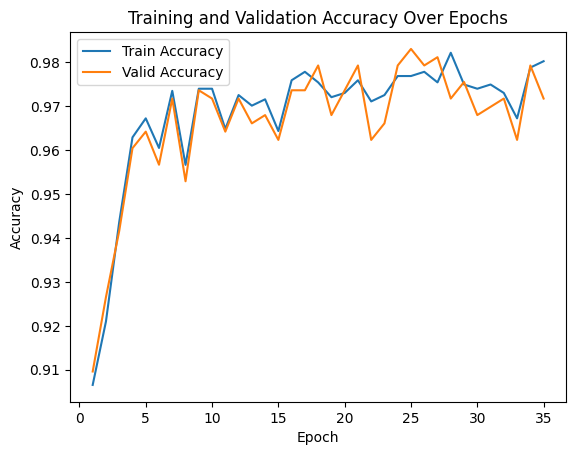

In [ ]:
# Plot the accuracy change with epochs
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Comparing to the other curves, we can see the validation accuracy doing significantly well comparing to the training accuracy

Best Accuracy on Test Set (ResNet): 97.84%


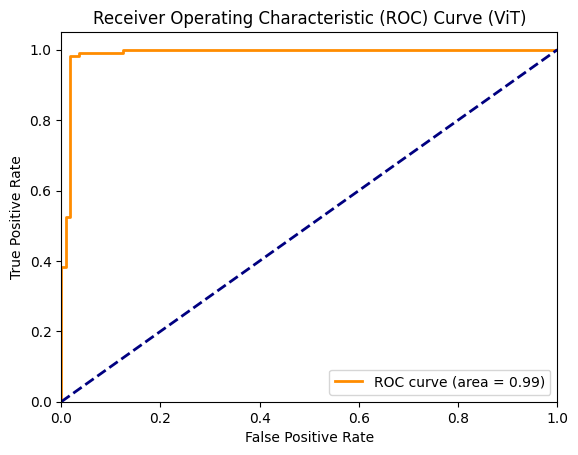

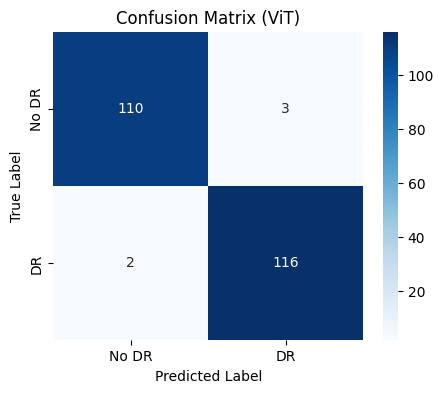

In [ ]:
# Load the best model and evaluate it on the test set
vit_model.load_state_dict(best_model_vit)
vit_model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

test_accuracy_vit = test_correct / test_total
print(f'Best Accuracy on Test Set (ResNet): {100 * test_accuracy_vit:.2f}%')

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Plot ROC Curve for ResNet
fpr_vit, tpr_vit, thresholds_vit = roc_curve(all_labels, all_predictions)
roc_auc_vit = auc(fpr_vit, tpr_vit)

plt.figure()
plt.plot(fpr_vit, tpr_vit, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_vit:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (ViT)')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for ResNet
cm_vit = confusion_matrix(all_labels, (all_predictions > 0.5).astype(int))
plt.figure(figsize=(5, 4))
sns.heatmap(cm_vit, annot=True, fmt="d", cmap="Blues", xticklabels=["No DR", "DR"], yticklabels=["No DR", "DR"])
plt.title("Confusion Matrix (ViT)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
vit_sensitivity = 110/112
vit_specificity = 116/119

In [ ]:
print(test_accuracy_resnet)
print(test_accuracy_effnet)
print(test_accuracy_mbnet)
print(test_accuracy_vit)

0.9567099567099567
0.9783549783549783
0.9783549783549783
0.9783549783549783


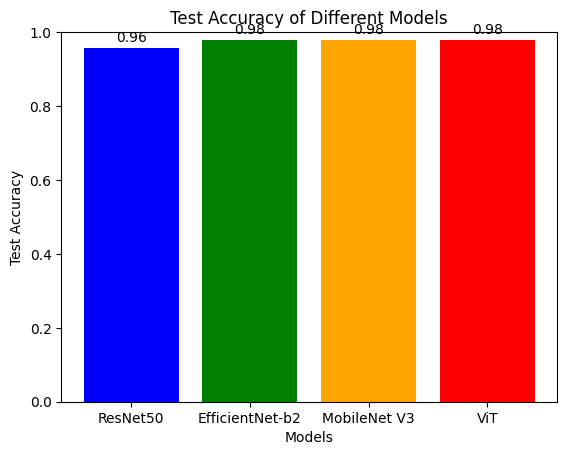

In [ ]:
# Variables and their corresponding test accuracies
models = ['ResNet50', 'EfficientNet-b2', 'MobileNet V3', 'ViT']
test_accuracies = [test_accuracy_resnet, test_accuracy_effnet, test_accuracy_mbnet, test_accuracy_vit]

# Plotting the bar chart
plt.bar(models, test_accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1 (assuming accuracy values are in the range 0 to 1)

# Display the test accuracy values on top of the bars
for i, accuracy in enumerate(test_accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


based on the test accuracy results for different pre-trained models:

Comparing Performance of Various Pre-trained Models for DR Diagnosis:

The test accuracies for the different models are as follows:

ResNet50: 95.67%
EfficientNet-b2: 97.83%
MobileNet V3: 97.83%
ViT (Vision Transformer): 97.83%
These accuracy values suggest that all models perform very well in diagnosing diabetic retinopathy (DR). The test accuracies are quite high, with EfficientNet-b2, MobileNet V3, and ViT achieving the highest accuracy of 97.83%.

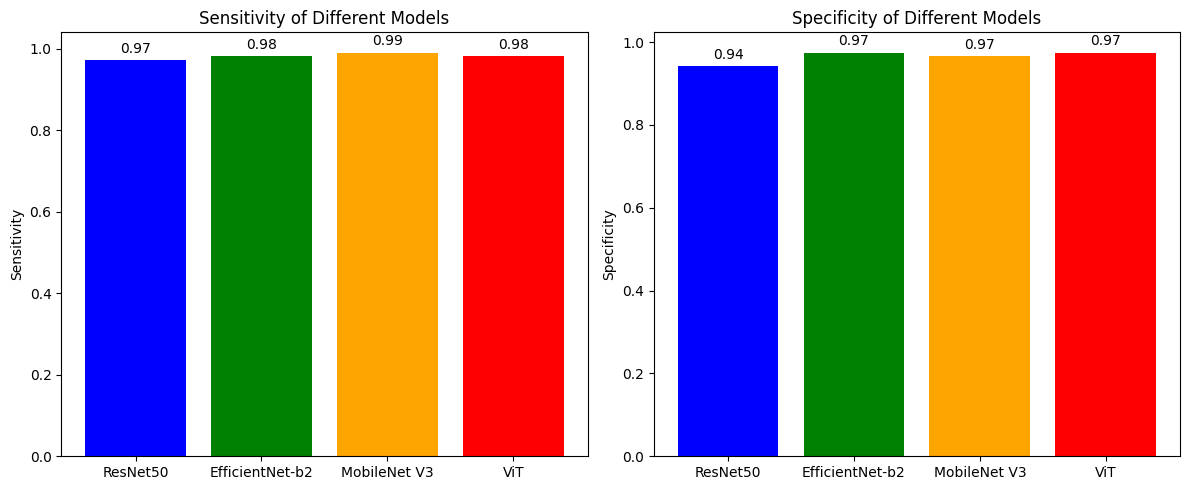

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity and Specificity values
models = ['ResNet50', 'EfficientNet-b2', 'MobileNet V3', 'ViT']
sensitivity = [106/109, 110/112, 109/110, 110/112]
specificity = [115/122, 116/119, 117/121, 116/119]

# Plotting the bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Bar chart for Sensitivity
axes[0].bar(models, sensitivity, color=['blue', 'green', 'orange', 'red'])
axes[0].set_title('Sensitivity of Different Models')
axes[0].set_ylabel('Sensitivity')

# Bar chart for Specificity
axes[1].bar(models, specificity, color=['blue', 'green', 'orange', 'red'])
axes[1].set_title('Specificity of Different Models')
axes[1].set_ylabel('Specificity')

# Display the values on top of the bars
for ax in axes:
    for i, val in enumerate(ax.patches):
        ax.text(val.get_x() + val.get_width() / 2, val.get_height() + 0.01,
                f'{val.get_height():.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Given that all models have a high ROC-AUC value (0.99), it indicates that they have near-perfect discriminatory power. Here's a brief interpretation:

A value of 0.99 is very close to the maximum value of 1.0, indicating that the models have an excellent ability to distinguish between positive and negative cases.
The models' predictions result in high true positive rates and low false positive rates across different classification thresholds.

Consistency: The consistency of the high ROC-AUC across all models suggests that each model is performing very well in terms of discrimination.
High Confidence: The models are making predictions with high confidence, which is a positive sign in a diagnostic or classification task.


Sensitivity:

EfficientNet-b2, MobileNet V3, and ViT have similar sensitivity values, indicating that they perform similarly in correctly identifying positive cases.
ResNet50 has a slightly lower sensitivity compared to the other models.

Specificity:

All models have relatively high specificity values, and there is less variation between them.
ViT has the highest specificity, followed closely by EfficientNet-b2 and MobileNet V3.
ResNet50 has a slightly lower specificity compared to the other models.

Conclusion:
In terms of sensitivity and specificity:

EfficientNet-b2, MobileNet V3, and ViT demonstrate similar and strong performance in correctly identifying both positive and negative cases.
ResNet50 shows slightly lower sensitivity and specificity compared to the other models.
For a more comprehensive evaluation, it's beneficial to consider both sensitivity and specificity, as they provide insights into different aspects of model performance. In this case, ViT appears to have a balanced and strong performance in terms of sensitivity and specificity.

Analyzing the ethical implications, potential harms, or biases related to the described dataset and models involves considering several key aspects:

Ethical Implications and Potential Harms
Data Privacy and Consent: High-resolution retinal images are sensitive personal health data. It's crucial to ensure that the data was collected with informed consent and is being used in compliance with data protection laws (like GDPR or HIPAA). Misuse or unauthorized access to such data could lead to privacy breaches.

Misdiagnosis Risks: Automated systems for disease detection and grading, while beneficial, carry the risk of misdiagnosis. False negatives might lead to delayed treatment, while false positives could cause unnecessary anxiety or treatment. The reliability and accuracy of these systems must be continuously monitored and improved.

Over-reliance on Technology: There's a risk that healthcare providers might over-rely on automated systems, potentially undermining their clinical judgment. It's important to use these systems as assistive tools rather than definitive decision-makers.

Biases in the Dataset and Models
Representation Bias: Does the dataset adequately represent the diverse population affected by Diabetic Retinopathy? Factors like ethnicity, age, and underlying health conditions can affect retinal appearance. A lack of diversity can lead to biased algorithms that perform well for some groups but not for others.

Annotation Bias: The grades assigned by medical professionals could be subjective. Inter-rater variability might introduce inconsistencies in the dataset, affecting the learning process of models.

Model Generalization: EfficientNet-b2, MobileNet V3, ViT, and ResNet50 have their own architectural strengths and weaknesses. Their performance in real-world, diverse clinical settings needs to be validated. A model that performs well on a specific dataset might not generalize well to other datasets or real-world scenarios.

Addressing These Issues
Data Privacy: Implementing strict data governance policies, ensuring all data is anonymized and stored securely.

Diverse and Inclusive Dataset: Ensuring the dataset covers a wide range of demographics and imaging conditions to reduce representation bias.

Continuous Evaluation: Regularly updating and testing the models against new data to ensure they adapt to changing real-world conditions.

Human Oversight: Maintaining human oversight in the decision-making process, especially for critical healthcare decisions.

Transparent Reporting: Clearly reporting the performance metrics of each model, including their limitations, to ensure informed usage by healthcare professionals.

Cross-Validation with Multiple Models: Using a combination of models (like EfficientNet-b2, MobileNet V3, ViT, ResNet50) for validation can reduce the risk of biases inherent in a single model.

In summary, while the dataset and models used hold immense potential for advancing DR detection, it's vital to address ethical concerns, potential harms, and biases to ensure they are used responsibly and effectively in clinical settings.